In [43]:
# Importing all used liberaries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms


# CNN Model Arch. is defindw here
class LabItemClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LabItemClassifier, self).__init__()
        # Convolutional layers (3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # connected layers (2 linear layers)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Assuming input images are 64x64
        self.fc2 = nn.Linear(256, num_classes)
        
        # Pooling layer (1)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layers (1)
        self.dropout = nn.Dropout(p=0.5)  # Drop 50% during training
        
    def forward(self, x):
        # layers w/ ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten feature maps before passing through connected layers
        x = x.view(-1, 128 * 8 * 8)
        
        # connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Define the number of classes (screws, resistors, wires, other tools)
num_classes = 4

# Def transformations for the images (resize,convert to tensor)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 pixels
    transforms.ToTensor()         # Convert to PyTorch tensors
])

#import os

# Define the path to the image
#image_path = os.path.join("MLModel", "dataset", "train", "resistors", "images(77).jpg")

# Check if the image exists at the specified path
#if os.path.exists(image_path):
    #print(f"Image found at path: {image_path}")
#else:
    #print(f"Image not found at path: {image_path}")




   
    






In [44]:
# Load the training/val datasets
    #originally used following code... now i commenred it
        #train_data = datasets.ImageFolder(root='dataset/train', transform=transform)
        #val_data = datasets.ImageFolder(root='dataset/val', transform=transform)
import os

# Function to filter out invalid files
def is_valid_file(filepath):
    # Exclude the .ipynb_checkpoints folder
    if '.ipynb_checkpoints' in filepath:
        return False
    return filepath.endswith(('.png', '.jpg', '.jpeg', 'JPEG'))  # Valid image extensions

# Load the training/val datasets with the is_valid_file filter
train_data = datasets.ImageFolder(root='dataset/train', transform=transform, is_valid_file=is_valid_file)
val_data = datasets.ImageFolder(root='dataset/val', transform=transform, is_valid_file=is_valid_file)


# DataLoaders for batching
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # essentially loads data in batches so that memory isn't used for the entire dataset at once.
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Initialize the model, loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LabItemClassifier(num_classes=num_classes).to(device)

#optimizer helps adjust model paramaters to reduce loss
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adam optimizer with learning rate 0.001

# Number of epochs (complete passes through the training data)
num_epochs = 10

# Initialize TensorBoard
writer = SummaryWriter('runs/lab_item_classifier_experiment')

# Data Augmentation: Adding slight distortions, flips, or negative samples
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Update training with this augmentation to prevent overfitting
train_data = datasets.ImageFolder(root='dataset/train', transform=transform_train, is_valid_file=is_valid_file)


In [45]:
# Training loop
for epoch in range(num_epochs):# Loop over each epoch
    model.train()# Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): # Loop over batches of data
        images, labels = images.to(device), labels.to(device)# Move data to GPU/CPU

        outputs = model(images) # Perform a forward pass to get predictions
        loss = criterion(outputs, labels) # Calculate the loss (difference from true labels)

        optimizer.zero_grad() # Reset gradients from the previous step
        loss.backward() # Backpropagate the loss to compute gradients
        optimizer.step()  # Update the model parameters using the optimizer


        running_loss += loss.item()  # Accumulate the batch loss for reporting

        # Log the loss for each batch
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + i)


# Data Augmentation: Adding slight distortions, flips, or negative samples
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Update training with this augmentation to prevent overfitting
train_data = datasets.ImageFolder(root='dataset/train', transform=transform_train, is_valid_file=is_valid_file)


In [46]:
 # Calculate and print average loss for this epoch
avg_loss = running_loss / len(train_loader)
print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
writer.add_scalar('Average Loss per Epoch', avg_loss, epoch)


# Data Augmentation: Adding slight distortions, flips, or negative samples
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Update training with this augmentation to prevent overfitting
train_data = datasets.ImageFolder(root='dataset/train', transform=transform_train, is_valid_file=is_valid_file)


Epoch [10/10], Loss: 0.0049


In [47]:
 # Validation step
model.eval()  # Set model to evaluation m
correct = 0
total = 0
with torch.no_grad():  # Disable gradient 
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get index of max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
# Validation accuracy
val_accuracy = 100 * correct / total
print(f'Standard Validation Accuracy: {val_accuracy:.2f}%')
writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

writer.close()


    

Standard Validation Accuracy: 96.35%


In [54]:


# Define class names for results
class_names = ['screws', 'resistors', 'pcb_components']
# Additional validation step to introduce misclassification logic:
non_class_samples = datasets.ImageFolder(root='extra_data/misclassified', transform=transform)
misclass_loader = DataLoader(non_class_samples, batch_size=32, shuffle=False)

correct_negatives = 0
for images, labels in misclass_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    correct_negatives += (predicted != labels).sum().item()  # Ensure no misclassification occurs
    
# Percentage cal ulations
correct_negative_rate = (correct_negatives / len(non_class_samples)) * 100
incorrect_negative_rate = 100 - correct_negative_rate

print(f"Correct Negative Classification Rate (%): {correct_negative_rate:.2f}%")
print(f"Incorrect Negative Classification Rate (%): {incorrect_negative_rate:.2f}%")


print(f'Correct Negative Classification Rate: {correct_negatives}/{len(non_class_samples)}')

Correct Negative Classification Rate (%): 91.90%
Incorrect Negative Classification Rate (%): 8.10%
Correct Negative Classification Rate: 692/753


In [59]:


# Function for predictions on a single new image
def classify_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Ensure the image has 3 channels (convert grayscale to RGB if necessary)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Preprocess the image
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move image to the same device as the model
    image = image.to(device)

    # Predict
    model.eval()  # Set model to evaluation
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    # Get the class name from class_names
    predicted_label = class_names[predicted_class.item()]
    print(f"Predicted class: {predicted_label}")
    return predicted_label


# Example usage (after training is complete):
classify_image('/Users/sumedhab/ML_Model/test/resistors/1K_1-4W_(50).jpg')





Predicted class: resistors


'resistors'

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import numpy as np

# Assuming y_true and y_pred are lists of labels
y_true = np.array(y_true)  # Ensure both are numpy arrays
y_pred = np.array(y_pred)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Model Accuracy on Test Set: {accuracy:.2f}")
print("\nDetailed Metrics:")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Display classification report
class_names = ["pcb_components", "resistors", "screws"]  # Replace with your actual class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Model Accuracy on Test Set: 0.96

Detailed Metrics:
Weighted Precision: 0.97
Weighted Recall: 0.96
Weighted F1-Score: 0.96

Confusion Matrix:
[[200   0   0]
 [  0 186   0]
 [  6  11  63]]

Classification Report:
                precision    recall  f1-score   support

pcb_components       0.97      1.00      0.99       200
     resistors       0.94      1.00      0.97       186
        screws       1.00      0.79      0.88        80

      accuracy                           0.96       466
     macro avg       0.97      0.93      0.95       466
  weighted avg       0.97      0.96      0.96       466



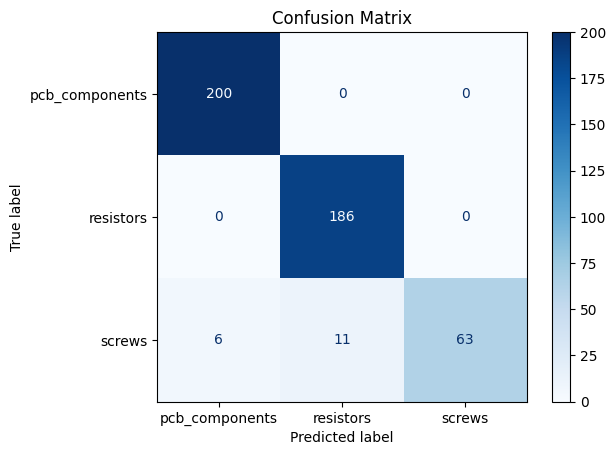

In [52]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect predictions (y_pred) and true labels (y_true) during evaluation
y_true = []
y_pred = []

# Set model to evaluation mode
model.eval()

# No gradient calculation needed during evaluation
with torch.no_grad():
    for images, labels in val_loader:  # Replace val_loader with your validation/test DataLoader
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions from the model
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Predicted class indices
        
        # Store true labels and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)  # Replace train_data.classes with your class labels if needed

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
